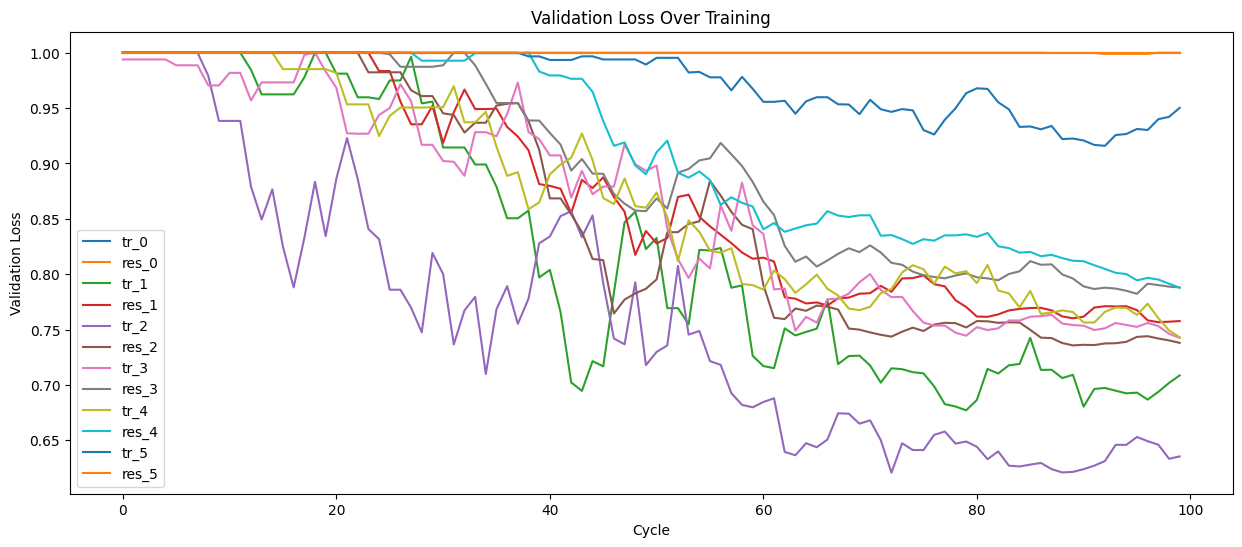

In [1]:
import torch
import matplotlib.pyplot as plt
from trainSettingsFramerate import *
from helpers.helpersPlot import *
import pandas as pd
import seaborn as sns


%load_ext autoreload
%reload_ext autoreload
%autoreload 2

def smooth_array(arr, n):
    pad = n // 2
    padded = np.pad(arr, pad, mode='edge')
    kernel = np.ones(n) / n
    smoothed = np.convolve(padded, kernel, mode='valid')
    return smoothed

# Load training results
results = torch.load("training_results_Framerate.pth",map_location=torch.device('cpu'))

# Extract data
validation_losses = results["validation_losses"]
all_labels = results["all_labels"]
model_weights = results["model_weights"]
plt.figure(figsize=(15, 6))  # <-- Add this line to control figure size


# Example: Plot validation loss curves
for model_name, losses in validation_losses.items():
    plt.plot(smooth_array(np.clip(losses["val_avg"],0,1), 5), label=model_name)

plt.xlabel("Cycle")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Validation Loss Over Training")
plt.show()



In [2]:
trajs1 = np.load("../validation_trajectories/"+str(30)+"/val7.npy") /traj_div_factor
vid1 = trajs_to_vid_framerates(trajs1[:1],nPosPerFrame,center=center,image_props=image_props)
vid= vid1[0] 
print(vid1.shape)

noise_i = 4
vmin, vmax = None, None
play_video(vid[0], vmin=vmin, vmax=vmax)
#play_video(vid[1,noise_i])
play_video(vid[2], vmin=vmin, vmax=vmax)
#play_video(vid[3,noise_i])
play_video(vid[4], vmin=vmin, vmax=vmax)

torch.Size([1, 6, 60, 13, 13])
vmin: -0.30466920137405396 vmax: 1.402417540550232 mean: 0.16


vmin: -0.11745790392160416 vmax: 0.9658267498016357 mean: 0.03


vmin: -0.047636765986680984 vmax: 0.8179146647453308 mean: 0.01


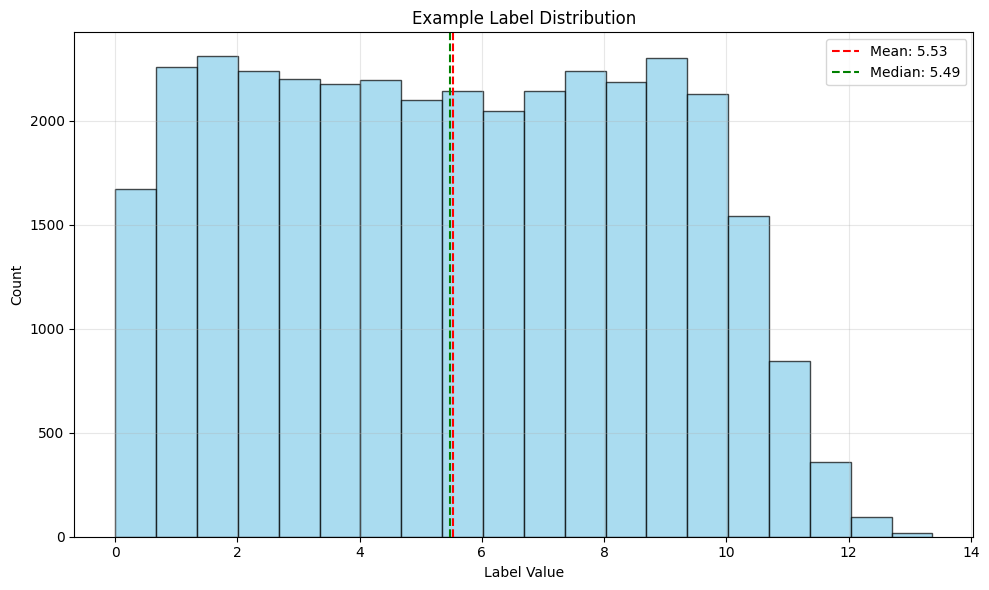

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_labels_histogram(labels_array, bins=10, title="Distribution of Labels", 
                          xlabel="Value", ylabel="Frequency", 
                          color='skyblue', edgecolor='black',
                          figsize=(10, 6), show_grid=True, 
                          show_mean=True, show_median=True):
    """
    Plot a histogram from a numpy array of labels.
    
    Parameters:
    -----------
    labels_array : numpy.ndarray
        The array of values to plot as histogram
    bins : int or sequence, default=10
        Number of bins or bin edges
    title : str, default="Distribution of Labels"
        Title of the plot
    xlabel : str, default="Value"
        Label for x-axis
    ylabel : str, default="Frequency"
        Label for y-axis
    color : str, default='skyblue'
        Color of the histogram bars
    edgecolor : str, default='black'
        Color of the histogram bar edges
    figsize : tuple, default=(10, 6)
        Figure size (width, height) in inches
    show_grid : bool, default=True
        Whether to show grid lines
    show_mean : bool, default=True
        Whether to show the mean line
    show_median : bool, default=True
        Whether to show the median line
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
        For further customization if needed
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot histogram
    ax.hist(labels_array, bins=bins, color=color, edgecolor=edgecolor, alpha=0.7)
    
    # Add mean line if requested
    if show_mean and len(labels_array) > 0:
        mean_value = np.mean(labels_array)
        ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5, 
                  label=f'Mean: {mean_value:.2f}')
    
    # Add median line if requested
    if show_median and len(labels_array) > 0:
        median_value = np.median(labels_array)
        ax.axvline(median_value, color='green', linestyle='dashed', linewidth=1.5,
                  label=f'Median: {median_value:.2f}')
    
    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    # Add grid
    if show_grid:
        ax.grid(alpha=0.3)
    
    # Add legend if we have mean or median
    if (show_mean or show_median) and len(labels_array) > 0:
        ax.legend()
    
    plt.tight_layout()
    
    return fig, ax

# Example usage
if __name__ == "__main__":
    # Example data
    
    # Plot histogram
    fig, ax = plot_labels_histogram(
        all_labels, 
        bins=20,
        title="Example Label Distribution",
        xlabel="Label Value",
        ylabel="Count"
    )
    
    plt.show()

In [4]:

models, optimizers, schedulers = getTrainingModels()

name_map = {n:n for n in list(models.keys())}

# Load model weights
for name, model in models.items():
    if name in model_weights:
        model.load_state_dict(model_weights[name])
        model.eval()  # Set to evaluation mode
        print(f"Loaded weights for {name}")
        print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    else:
        print(f"Warning: No saved weights found for {name}")

Loaded weights for tr_0
506081
Loaded weights for res_0
315617
Loaded weights for tr_1
506081
Loaded weights for res_1
315617
Loaded weights for tr_2
506081
Loaded weights for res_2
315617
Loaded weights for tr_3
506081
Loaded weights for res_3
315617
Loaded weights for tr_4
506081
Loaded weights for res_4
315617
Loaded weights for tr_5
506081
Loaded weights for res_5
315617


In [5]:
# Load validation dataset (fixed, does not change across cycles)
val_videos = load_validation_data(length=nFrames)  # Returns (vid1, vid3, vid5, vid7, vid9, vid_in_order)

val_vid_in_order = val_videos[5]


print(val_videos[0].shape,val_vid_in_order.shape)

print(val_d_in_order.shape)
val_labels = torch.tensor([1, 3, 5, 7, 9], dtype=torch.float32)  # Corresponding labels



torch.Size([50, 6, 60, 13, 13]) torch.Size([1000, 6, 60, 13, 13])
(100,)


In [6]:
def plot_model_predictions_violin(models, val_videos, val_labels, chosen_labels, selected_models):
    """
    Plots a 2x2 grid of violin plots for the predictions of all models for specific validation labels.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_videos (tuple): Tuple of validation video tensors.
    - val_labels (Tensor): Corresponding labels (torch.Tensor([1, 3, 5, 7]) for example).
    - chosen_labels (list): List of validation labels to visualize (e.g., [7.0, 3.0, 1.0]).
    """
    
    # Check that all chosen labels are in the validation labels
    for chosen_label in chosen_labels:
        if chosen_label not in val_labels.tolist():
            print(f"Error: Chosen label {chosen_label} not in available labels {val_labels.tolist()}")
            return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 14))  # Create a 2x2 grid of subplots
    axes = axes.flatten()  # Flatten axes for easy iteration

    # Loop over the chosen labels and corresponding axes
    for idx, chosen_label in enumerate(chosen_labels):
        label_idx = val_labels.tolist().index(chosen_label)
        chosen_video = val_videos[label_idx]  # Get corresponding video

        predictions = {}

        # Compute predictions for each model
        for name, model in models.items():
            if(name in selected_models):
                model.eval()
                with torch.no_grad():
                    preds = make_prediction(model, name, chosen_video)
                    if("MSD" not in name):
                        preds = preds.squeeze().numpy()  # Get all predictions for this video
                    # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
                    predictions[name_map[name]] = preds * D_max_normalization  

        # Prepare data for Seaborn
        data = []
        for model_name, preds in predictions.items():
            for pred in preds:
                data.append({"Model": model_name, "Prediction": pred})

        # Convert to DataFrame for easy plotting
        df = pd.DataFrame(data)

        # Plot violin plot in the corresponding subplot
        sns.violinplot(x="Model", y="Prediction", data=df, inner="box", hue="Model", palette="coolwarm", ax=axes[idx])

        # Add reference line for true label
        axes[idx].axhline(y=chosen_label, color='r', linestyle='--', label=f"True Value: {chosen_label}")

        axes[idx].set_xlabel("Model")
        axes[idx].set_ylabel("Predicted Value")
        axes[idx].set_title(f"Model Predictions for Label {chosen_label}")
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].legend()

    plt.tight_layout()  # Adjust subplots to fit nicely
    plt.show()

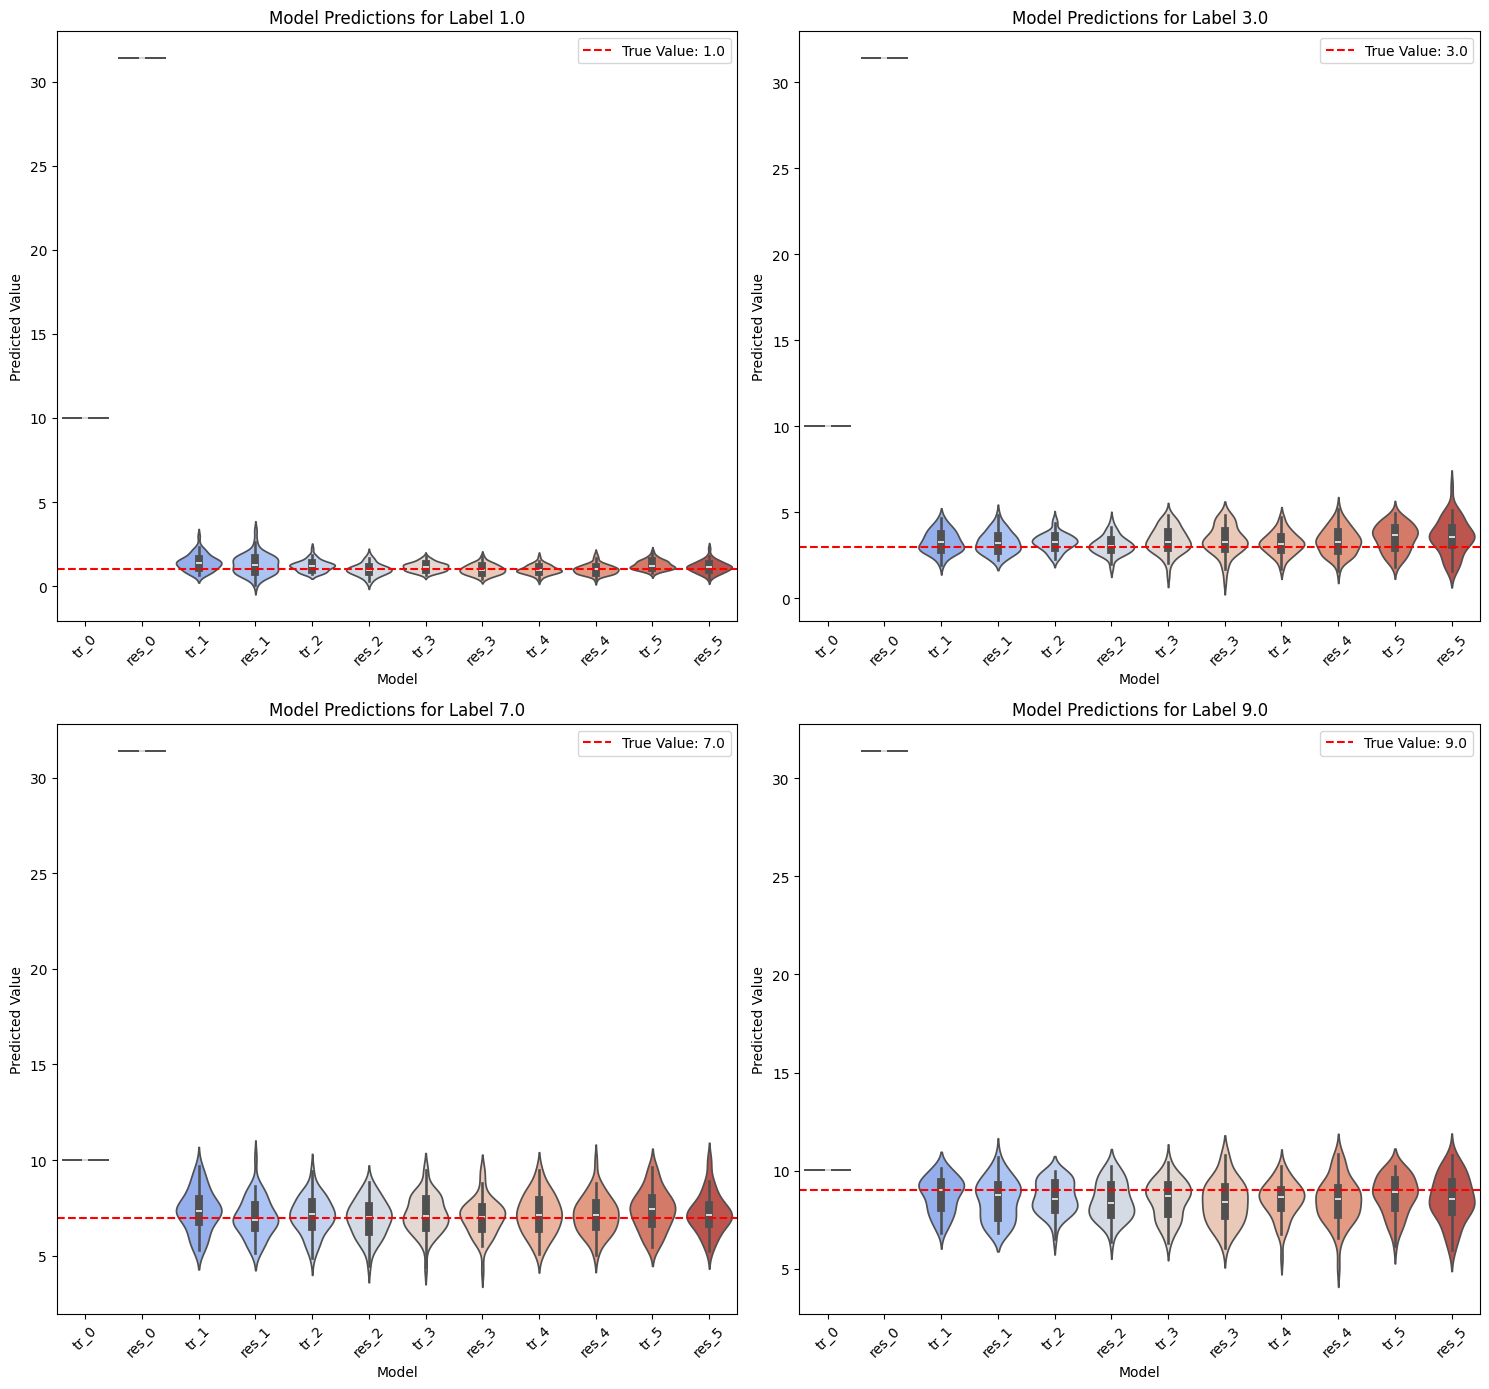

In [7]:
# Example usage
chosen_labels = [1.0, 3.0, 5.0, 7.0]
chosen_labels = [1.0, 3.0,  7.0, 9.0]
selected_models = models.keys()
plot_model_predictions_violin(models, val_videos, val_labels, chosen_labels,selected_models)

In [8]:
def plot_mse_vs_num_images(models, val_videos, val_labels, chosen_label, selected_models):
    """
    Plots the Mean Squared Error (MSE) of model predictions as a function of num_images.
    
    Args:
    - models (dict): Dictionary of model names and instances.
    - val_videos (tuple): Tuple of validation video tensors.
    - val_labels (Tensor): Corresponding labels (torch.Tensor([1, 3, 5, 7])).
    - chosen_label (int): The validation label to visualize (must be 1, 3, 5, or 7).
    """
    
    
    # Find index of the chosen label
    if chosen_label not in val_labels.tolist():
        print(f"Error: Chosen label {chosen_label} not in available labels {val_labels.tolist()}")
        return
    
    label_idx = val_labels.tolist().index(chosen_label)
    chosen_video = val_videos[label_idx][0]  # Get corresponding video


    num_images_range = range(1, chosen_video.shape[1] + 1)  # Range of num_images
    mse_results = {name_map[name]: [] for name in selected_models}  # Store MSE results
    
    for num_images in num_images_range:
        input_video = chosen_video[:,:,:,:num_images]  # Select subset of images



        for name, model in models.items():
            if(name in selected_models):                    
                    pred = make_prediction(model,name,input_video.contiguous()).mean().item() 
                    # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
                    pred = pred * D_max_normalization 
                    mse = (pred - chosen_label) ** 2  # Compute MSE
                    mse_results[name_map[name]].append(mse)
    
    # Plot MSE as a function of num_images
    plt.figure(figsize=(10, 6))
    for name, mse_values in mse_results.items():
        plt.plot(num_images_range, mse_values, label=name)
    
    plt.xlabel("Number of Images")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title(f"MSE of Model Predictions vs. Num Images (Label {chosen_label})")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()

selected_models = models.keys()
#plot_mse_vs_num_images(models, val_videos, val_labels, 7, selected_models)

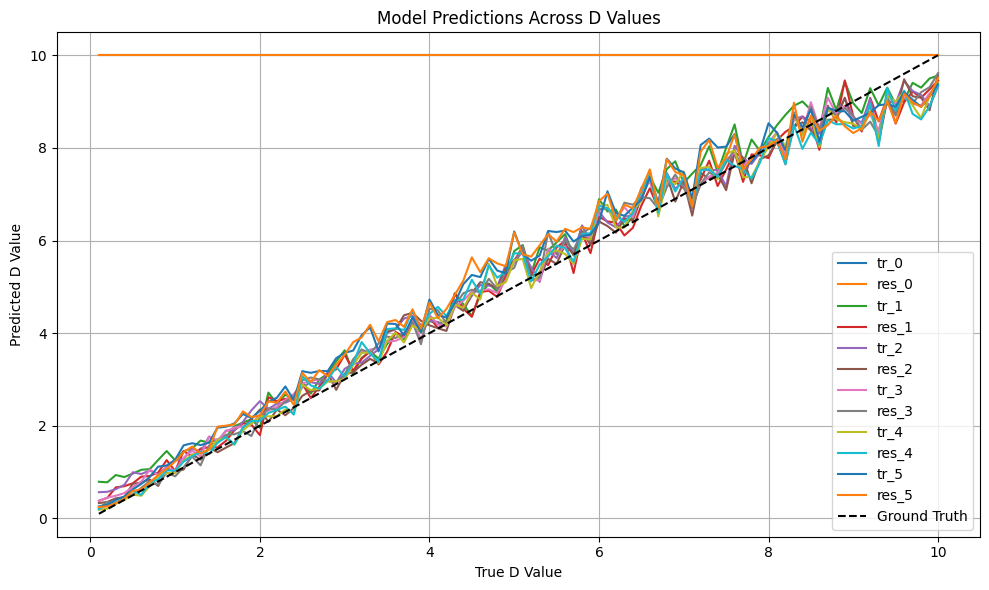

In [18]:

def plot_model_predictions_vs_D_in_order(models, val_vid_in_order, val_d_in_order):
    """
    Plots line graphs of model predictions across increasing D values.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_vid_in_order (numpy array or torch.Tensor): Array of shape (70, 10, 30, 7, 7).
    - val_d_in_order (list or array): Corresponding true D values (length 70).
    """

    val_vid_in_order = val_vid_in_order.reshape(100,10,6,60,13,13)

    model_preds = {name_map[name]: [] for name in models.keys()}

    for i in range(len(val_d_in_order)):
        vids = val_vid_in_order[i]  # shape (6,10, 30, 7, 7)


        for name in models.keys():
            model = models[name]


            preds = make_prediction(model, name, vids)

            # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
            preds = preds * D_max_normalization
            mean_of_means = preds.mean().item()  # mean over sequences
            mean_of_means = np.clip(mean_of_means,0,10)
            model_preds[name_map[name]].append(mean_of_means)

    return model_preds
def plotModePredsvsDInorder(model_preds, val_d_in_order, selected_models):
    # Plot
    plt.figure(figsize=(10, 6))
    for name, preds in model_preds.items():
        if (name in selected_models):
            plt.plot(val_d_in_order, preds, label=name)

    plt.plot(val_d_in_order, val_d_in_order, 'k--', label='Ground Truth')  # y = x reference
    plt.xlabel("True D Value")
    plt.ylabel("Predicted D Value")
    plt.title("Model Predictions Across D Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


models_preds = plot_model_predictions_vs_D_in_order(models, val_vid_in_order ,val_d_in_order)
plotModePredsvsDInorder(models_preds, val_d_in_order, selected_models)

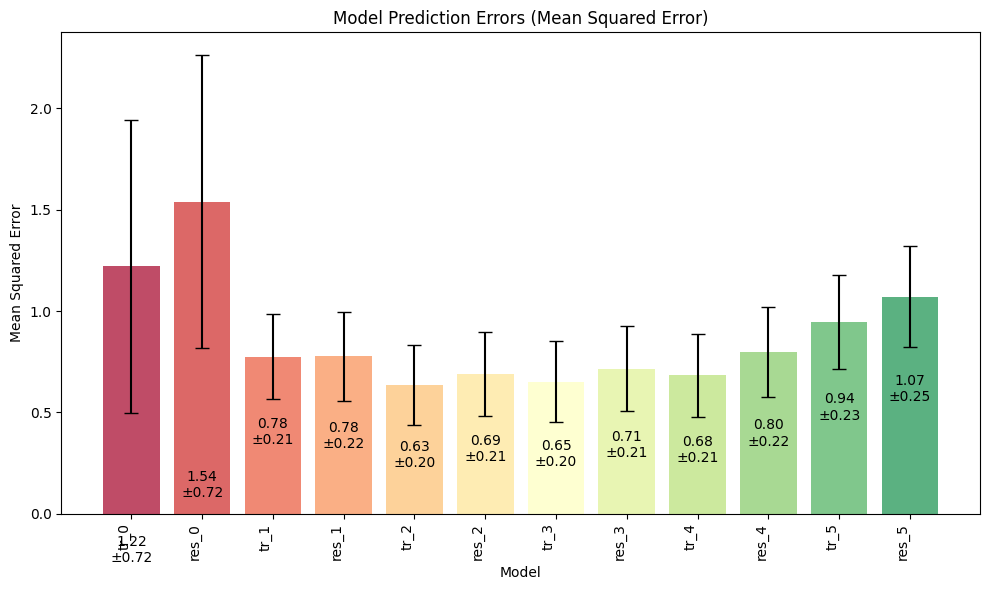

In [ ]:
import matplotlib.pyplot as plt

def plot_error_std(selected_models, mse_dict, std_dict, models_colormap):
    """
    Plot bar graph of Mean Squared Error with error bars representing standard deviation.

    Args:
    - selected_models (list): List of model names
    - mse_dict (dict): Dictionary of Mean Squared Errors for each model
    - std_dict (dict): Dictionary of standard deviations for each model
    - models_colormap (dict): Dictionary mapping model names to colors
    - name_map (dict): Dictionary mapping display names to internal names
    """
    plt.figure(figsize=(10, 6))
    
    colors = [models_colormap[name] for name in selected_models]

    # Prepare data
    model_names = list(selected_models)
    model_names_mapped = [name_map[name] for name in model_names]
    mean_errors = [mse_dict[name_map[name]] for name in model_names]
    std_errors = [std_dict[name_map[name]] for name in model_names]

    # Bar plot
    bars = plt.bar(model_names_mapped, mean_errors, yerr=std_errors, 
                   capsize=5, alpha=0.7, color=colors)
    
    plt.title('Model Prediction Errors (Mean Squared Error)')
    plt.xlabel('Model')
    plt.ylabel('Mean Squared Error')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()

    # Add error values slightly above the bar + std
    for i, (mean, std) in enumerate(zip(mean_errors, std_errors)):
        y = mean - 2*std - 0.02 * max(mean_errors)  # small offset
        plt.text(i, y, f'{mean:.2f}\n±{std:.2f}', ha='center', va='bottom')

    plt.show()



def compute_pred(model, val_vid, val_feat, val_trajs):

    with torch.no_grad():
            
        preds = make_prediction(model, name, val_vid, val_feat, val_trajs)
        return preds



def compute_erro_all_d(models, val_vid_in_order,val_d_in_order, selected_models):
    """
    Plots line graphs of model predictions and bar graph of errors across increasing D values.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_vid_in_order (numpy array or torch.Tensor): Array of shape (70, 10, 30, 7, 7).
    - val_d_in_order (list or array): Corresponding true D values (length 70).
    """


    if isinstance(val_d_in_order, np.ndarray):
        val_d_in_order = torch.tensor(val_d_in_order, dtype=torch.float32)


    # Reshape video tensor to (700, 30, 9, 9)
    val_vid_reshaped = val_vid_in_order.to(device)
    # Explicitly repeat val_d_in_order 10 times to create a (700,) array
    true_d_repeated = torch.repeat_interleave(val_d_in_order, repeats=10).unsqueeze(1)

    # Dictionaries to store predictions, MSE, and standard deviation
    model_preds = {name: [] for name in selected_models}
    mse_dict = {}
    std_dict = {}

    for name in selected_models:
        model = models[name]

        with torch.no_grad():
                
            preds = make_prediction(model, name, val_vid_reshaped)

            # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
            preds_np = preds * D_max_normalization

            # Extract numpy arrays from tensors
            if("MSD" not in name):
                preds_np = preds_np.cpu().numpy()
            else:
                preds_np = preds_np.reshape(len(val_d_in_order) *N_in_order,-1)
            true_np = true_d_repeated.cpu().numpy()


            errors = preds_np - true_np
            # Add epsilon to denominator to avoid division by zero
            epsilon = 1e-8
            #scaled_errors = errors / (true_np + epsilon)
            scaled_errors = errors
            # Step 3: Compute the scaled Mean Squared Error (MSE)
            scaled_mse = np.mean(scaled_errors**2)
            #scaled_mse = np.mean(np.abs(scaled_errors))

            # Step 4: Compute the standard deviation of the scaled squared errors
            scaled_std = np.std(scaled_errors)/4
            #scaled_std = np.std(np.abs(scaled_errors))

            # Store MSE and standard deviation
            mse_dict[name_map[name]] = scaled_mse
            std_dict[name_map[name]] = scaled_std

            # Potentially create prediction plot
            model_preds[name] = preds.mean().item()
    return mse_dict, std_dict



cmap = plt.get_cmap("RdYlGn")
colors_dict = { name : cmap(i/len(models)) for i,name in enumerate(models.keys())           
}
sel_models = list(colors_dict.keys())
mse_dict,std_dict = compute_erro_all_d(models, val_vid_in_order, val_d_in_order, sel_models)
plot_error_std(sel_models, mse_dict, std_dict, colors_dict)


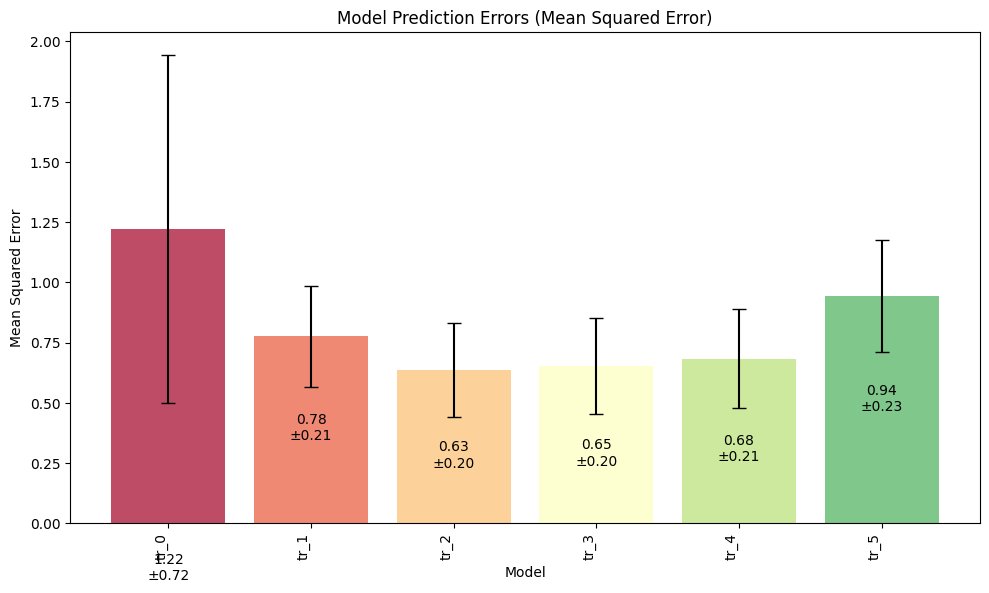

In [15]:
sel_models2 = [f for f in models.keys() if "tr" in f]
plot_error_std(sel_models2, mse_dict, std_dict, colors_dict)
